# Redes Neuronales
## Trabajo Práctico N° 1 - Ejercicio 2
* Kammann, Lucas Agustín
* Gaytan, Joaquín Oscar

### Consultas y/o dudas
* Es lógico glucosa = 0?
* Estimar probabilidades de un valor determinado en VAC
* Criterio para identificar outliers ("leve"?)

### To do
* Agregar cantidad de ceros por variable
* Explicación probabilística del clasificador
* Juntar las acciones repetitivas (gráficos) en funciones


# Descripción del problema
Se busca desarrollar un clasificador para poder predcir la aparición de diabetes en un individuo a partir de algunas de sus características biológicas. Dicha clasificación se realiza a partir del Prima Indians Diabetes Dataset, pereteneciente al National Institute of Diabetes and Digestive and Kidney Diseases. Esta base de datos comprende pacientes femeninos de al menos 21 años de edad, de herencia Prima Indian.

* INSERTAR CÓMO SE RESUELVE EL PROBLEMA A NIVEL PROBABILÍSTICO.

# Análisis y filtrado de la base de datos

En primer lugar, se importa la base de datos mencionada anteriormente para poder ser procesada. Además se muestran las primeras filas.

In [1]:
import pandas as pd

# Read database from .csv
df = pd.read_csv('../assets/diabetes.csv', delimiter=',')

# Show first rows of data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Como se observa en la tabla anterior, las variables a considerar para estimar la presencia de diabetes en una persona son las siguientes:

*   Pregnancies (embarazos): Número de embarazos
*   Glucose: Concentración de glucosa en sangre a 2 horas de una prueba de tolerancia de glucosa oral.
*   BloodPresure (Presión sanguinea): Presión diastólica (mm Hg)
*   SkinThickness: Tamaño del pliegue de la piel del triceps
*   Insulin: Insulina en sangre a 2 horas (mu U/ml)
*   BMI: Indice de masa corporal (peso en kg / (altura en metros)^2)
*   DiabetesPedigreeFunction: Una función que estima el likelihood de tener diabetes dado el historial familiar
*   Age: Edad (años)
*   Outcome: Variable 0 o 1 (0 no posee diabtes, 1 posee diabetes)

Antes de comenzar con el análisis estadístico de cada una de estas variables es necesario filtrar aquellos valores que no fueron informados. De lo contrario, estos valores sin sentido afectarán el desempeño del modelo al realizar la predicción.

## Filtrado de datos inválidos

In [2]:
# Show database variables and their characteristics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# Describing database
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


De la tabla anterior se aprecia que hay ciertas variables biológicas que adoptan valores inválidos. Por ejemplo, la presión sanguínea no puede ser nula. Lo mismo sucede con la glucosa, el grosor de la piel, el nivel de insulina, el ínidice de masa corporal. Luego, se reemplazan aquellos valores sin sentido por un NaN (not a number) para evitar que sean contemplados al realizar el análisis estadístico posterior.

In [4]:
import numpy as np

# Filtering Glucose values
df['Glucose'].replace(0, np.nan, inplace=True)

# Filtering Blood Pressure values
df['BloodPressure'].replace(0, np.nan, inplace=True)

# Filtering Skin Thickness values
df['SkinThickness'].replace(0, np.nan, inplace=True)

# Filtering Insulin values
df['Insulin'].replace(0, np.nan, inplace=True)

# Filtering Body Mass Index values
df['BMI'].replace(0, np.nan, inplace=True)

# Describing filtered dataset characterisics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Análisis de variables
Para cada variable involucrada se realiza un análisis estadístico, diferenciando entre aquellos casos positivos en diabetes y aquellos que no lo son.
### Embarazos ("Pregnancies")

In [5]:
import matplotlib.pyplot as plt

df["Pregnancies"].describe()

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

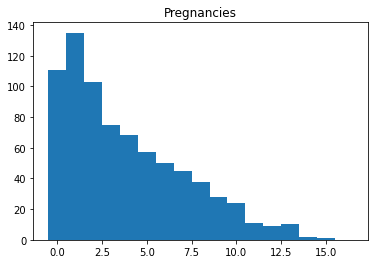

In [6]:
# Bins for discrete variable
pregBins = np.arange(-0.5,df["Pregnancies"].max()+0.5,1)
plt.hist(df['Pregnancies'], bins = pregBins)
x = plt.title("Pregnancies")

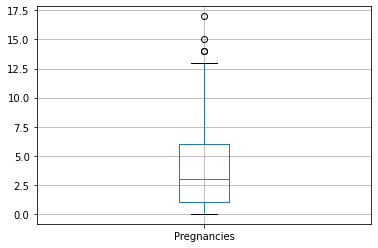

In [7]:
# Boxplot
df.boxplot(column=['Pregnancies'],return_type='axes');

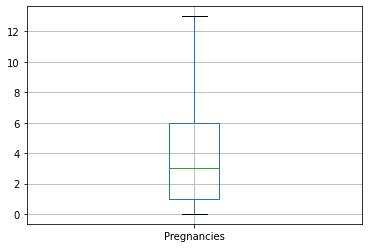

In [8]:
from scipy import stats
# Removing outliers from category

def getOutliers(df):
    # Usa criterio de "Outlier Leve"
    # extraído de https://es.wikipedia.org/wiki/Valor_at%C3%ADpico 
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    mean = df.mean()
    ret = []
    for value in df:
        if value < (q1 - 1.5 * iqr) or value > (q3 + 1.5 * iqr):
            ret.append(value)
    return ret

def removeOutliers(df): 
    outliers = getOutliers(df)
    for outlier in outliers:
        df.replace(outlier, np.nan, inplace=True)
        

     

removeOutliers(df['Pregnancies'])
df.boxplot(column=['Pregnancies'],return_type='axes');




In [9]:
# Pregnancies in diabetes-negative
df[df['Outcome'] == 0]['Pregnancies'].describe()

count    500.000000
mean       3.298000
std        3.017185
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       13.000000
Name: Pregnancies, dtype: float64

In [10]:
# Pregnancies in diabetes-positive
df[df['Outcome'] == 1]['Pregnancies'].describe()

count    264.000000
mean       4.712121
std        3.549820
min        0.000000
25%        1.000000
50%        4.000000
75%        7.250000
max       13.000000
Name: Pregnancies, dtype: float64

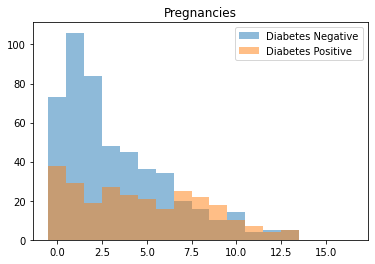

In [11]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['Pregnancies'], bins = pregBins, alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['Pregnancies'], bins = pregBins, alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Pregnancies')

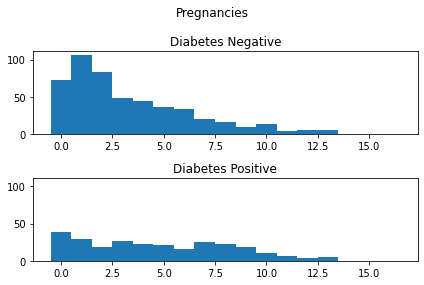

In [12]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Pregnancies')
axs[0].hist(df[df['Outcome'] == 0]['Pregnancies'], bins = pregBins)
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['Pregnancies'], bins = pregBins)
x = axs[1].set_title('Diabetes Positive')

### Glucosa ("Glucose")

In [13]:
df['Glucose'].describe()

count    763.000000
mean     121.686763
std       30.535641
min       44.000000
25%       99.000000
50%      117.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64

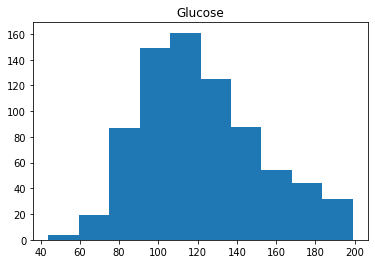

In [14]:
# Histogram 
plt.hist(df['Glucose'])
x = plt.title('Glucose')

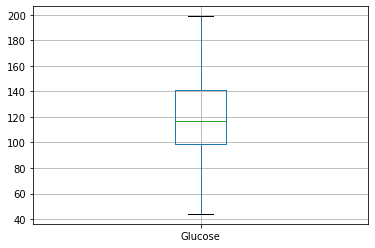

In [15]:
# Boxplot
df.boxplot(column=['Glucose'],return_type='axes');

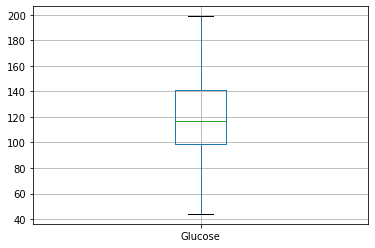

In [16]:
# Removing outliers from category  
removeOutliers(df['Glucose'])
df.boxplot(column=['Glucose'],return_type='axes');

In [17]:
# Glucose in diabetes-negative
df[df['Outcome'] == 0]['Glucose'].describe()

count    497.000000
mean     110.643863
std       24.776906
min       44.000000
25%       93.000000
50%      107.000000
75%      125.000000
max      197.000000
Name: Glucose, dtype: float64

In [18]:
# Glucose in diabetes-positive
df[df['Outcome'] == 1]['Glucose'].describe()

count    266.000000
mean     142.319549
std       29.599199
min       78.000000
25%      119.000000
50%      140.000000
75%      167.000000
max      199.000000
Name: Glucose, dtype: float64

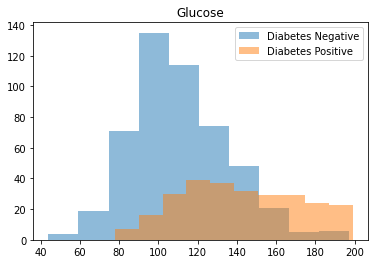

In [19]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['Glucose'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['Glucose'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Glucose')

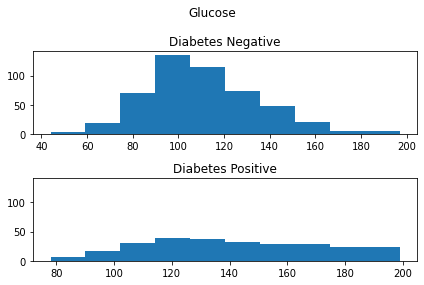

In [20]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Glucose')
axs[0].hist(df[df['Outcome'] == 0]['Glucose'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['Glucose'])
x = axs[1].set_title('Diabetes Positive')

### Presión Sanguínea ("BloodPressure")

In [21]:
df['BloodPressure'].describe()

count    733.000000
mean      72.405184
std       12.382158
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

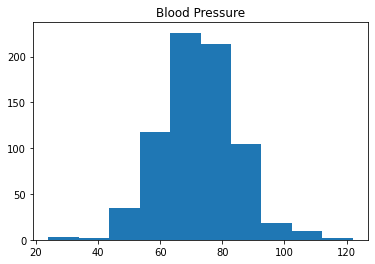

In [22]:
# Histogram 
plt.hist(df['BloodPressure'])
x = plt.title('Blood Pressure')

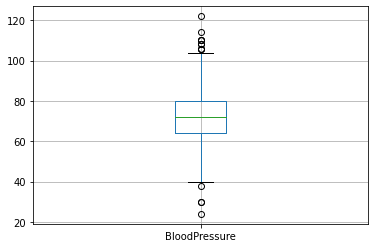

In [23]:
# Boxplot
df.boxplot(column=['BloodPressure'],return_type='axes');

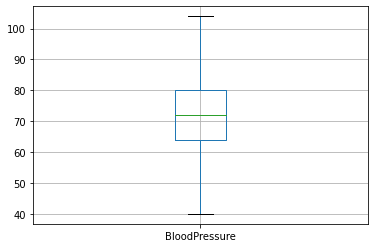

In [24]:
# Removing outliers from category
removeOutliers(df['BloodPressure'])
df.boxplot(column=['BloodPressure'],return_type='axes');

In [25]:
# Blood pressure in diabetes-negative
df[df['Outcome'] == 0]['BloodPressure'].describe()

count    473.000000
mean      70.714588
std       11.088862
min       44.000000
25%       62.000000
50%       70.000000
75%       78.000000
max      100.000000
Name: BloodPressure, dtype: float64

In [26]:
# Blood pressure in diabetes-positive
df[df['Outcome'] == 1]['BloodPressure'].describe()

count    246.000000
mean      74.808943
std       11.055338
min       40.000000
25%       68.000000
50%       74.000000
75%       82.000000
max      104.000000
Name: BloodPressure, dtype: float64

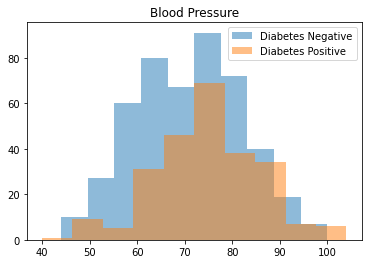

In [27]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['BloodPressure'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['BloodPressure'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Blood Pressure')

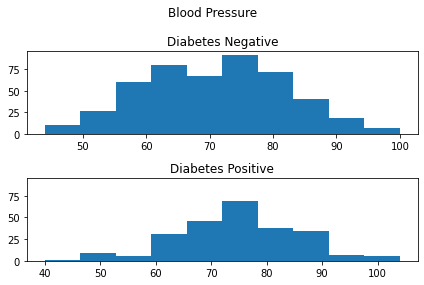

In [28]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Blood Pressure')
axs[0].hist(df[df['Outcome'] == 0]['BloodPressure'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['BloodPressure'])
x = axs[1].set_title('Diabetes Positive')

### Grosor de la piel del pliegue del tríceps ("SkinThickness")

In [29]:
df['SkinThickness'].describe()

count    541.000000
mean      29.153420
std       10.476982
min        7.000000
25%       22.000000
50%       29.000000
75%       36.000000
max       99.000000
Name: SkinThickness, dtype: float64

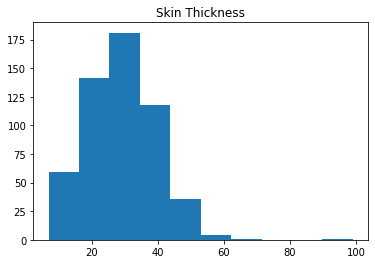

In [30]:
# Histogram 
plt.hist(df['SkinThickness'])
x = plt.title('Skin Thickness')

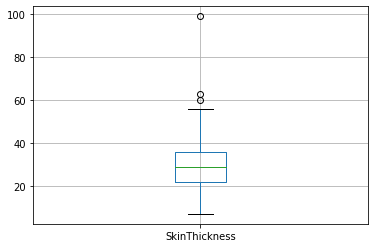

In [31]:
# Boxplot
df.boxplot(column=['SkinThickness'],return_type='axes');

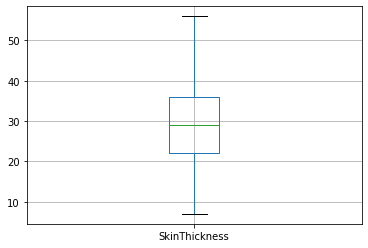

In [32]:
# Removing outliers from category
removeOutliers(df['SkinThickness'])
df.boxplot(column=['SkinThickness'],return_type='axes');

In [33]:
# Skin Thickness in diabetes-negative
df[df['Outcome'] == 0]['SkinThickness'].describe()

count    360.000000
mean      27.144444
std        9.889992
min        7.000000
25%       19.000000
50%       27.000000
75%       33.000000
max       54.000000
Name: SkinThickness, dtype: float64

In [34]:
# Skin Thickness in diabetes-positive
df[df['Outcome'] == 1]['SkinThickness'].describe()

count    178.000000
mean      32.460674
std        8.824793
min        7.000000
25%       27.000000
50%       32.000000
75%       39.000000
max       56.000000
Name: SkinThickness, dtype: float64

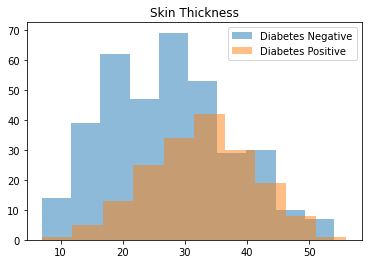

In [35]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['SkinThickness'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['SkinThickness'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Skin Thickness')

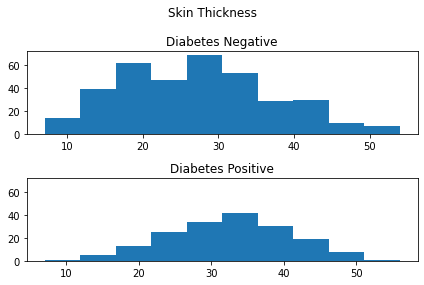

In [36]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Skin Thickness')
axs[0].hist(df[df['Outcome'] == 0]['SkinThickness'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['SkinThickness'])
x = axs[1].set_title('Diabetes Positive')

### Insulina ("Insulin")

In [37]:
df['Insulin'].describe()

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

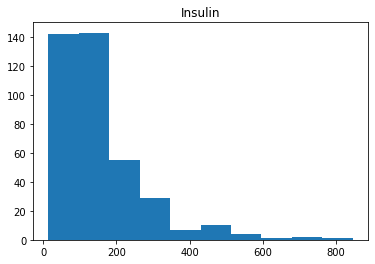

In [38]:
# Histogram 
plt.hist(df['Insulin'])
x = plt.title('Insulin')

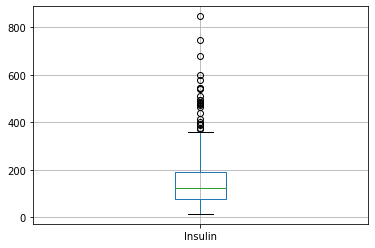

In [39]:
# Boxplot
df.boxplot(column=['Insulin'],return_type='axes');

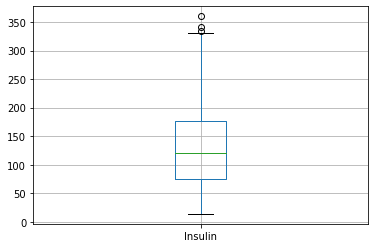

In [40]:
# Removing outliers from category
removeOutliers(df['Insulin'])
df.boxplot(column=['Insulin'],return_type='axes');

In [41]:
# Insulin in diabetes-negative
df[df['Outcome'] == 0]['Insulin'].describe()

count    254.000000
mean     115.917323
std       69.844697
min       15.000000
25%       64.250000
50%      100.000000
75%      151.000000
max      342.000000
Name: Insulin, dtype: float64

In [42]:
# Insulin in diabetes-positive
df[df['Outcome'] == 1]['Insulin'].describe()

count    116.000000
mean     169.163793
std       70.789454
min       14.000000
25%      124.250000
50%      160.000000
75%      207.750000
max      360.000000
Name: Insulin, dtype: float64

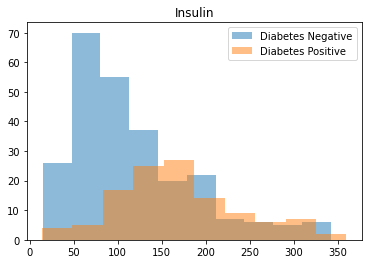

In [43]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['Insulin'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['Insulin'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Insulin')

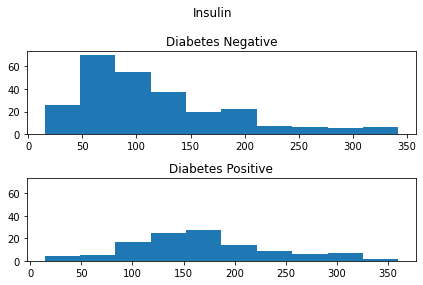

In [44]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Insulin')
axs[0].hist(df[df['Outcome'] == 0]['Insulin'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['Insulin'])
x = axs[1].set_title('Diabetes Positive')

### Índice de Masa Corporal ("BMI")

In [45]:
df['BMI'].describe()

count    757.000000
mean      32.457464
std        6.924988
min       18.200000
25%       27.500000
50%       32.300000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

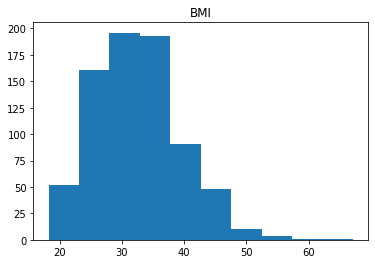

In [46]:
# Histogram 
plt.hist(df['BMI'])
x = plt.title('BMI')

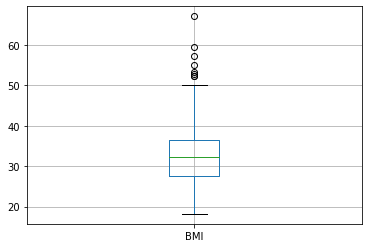

In [47]:
# Boxplot
df.boxplot(column=['BMI'],return_type='axes');

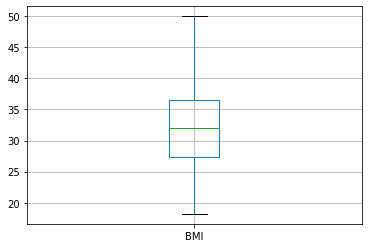

In [48]:
# Removing outliers from category
removeOutliers(df['BMI'])
df.boxplot(column=['BMI'],return_type='axes');

In [49]:
# BMI in diabetes-negative
df[df['Outcome'] == 0]['BMI'].describe()

count    489.000000
mean      30.761759
std        6.390268
min       18.200000
25%       25.600000
50%       30.100000
75%       35.300000
max       47.900000
Name: BMI, dtype: float64

In [50]:
# BMI in diabetes-posiitve
df[df['Outcome'] == 1]['BMI'].describe()

count    260.000000
mean      34.916538
std        5.782866
min       22.900000
25%       30.800000
50%       34.200000
75%       38.425000
max       50.000000
Name: BMI, dtype: float64

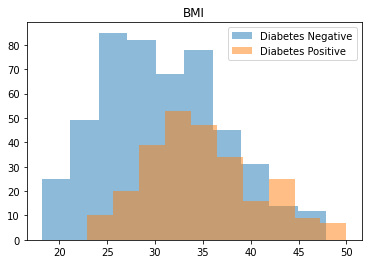

In [51]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['BMI'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['BMI'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('BMI')

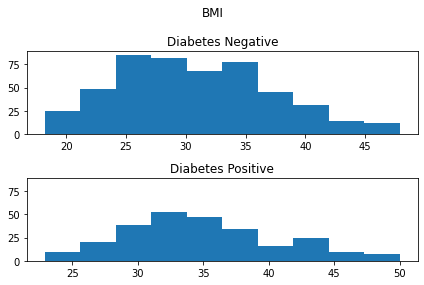

In [52]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('BMI')
axs[0].hist(df[df['Outcome'] == 0]['BMI'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['BMI'])
x = axs[1].set_title('Diabetes Positive')

### Diabetes Pedigree Function (DiabetesPedigreeFunction)

In [53]:
df['DiabetesPedigreeFunction'].describe()

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

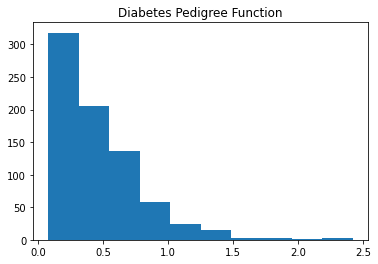

In [54]:
# Histogram 
plt.hist(df['DiabetesPedigreeFunction'])
x = plt.title('Diabetes Pedigree Function')

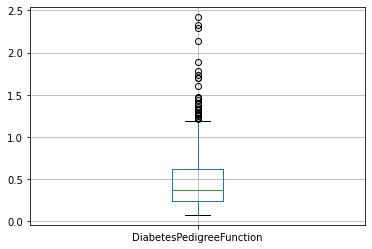

In [55]:
# Boxplot
df.boxplot(column=['DiabetesPedigreeFunction'],return_type='axes');

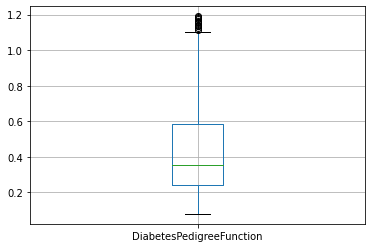

In [56]:
# Removing outliers from category
removeOutliers(df['DiabetesPedigreeFunction'])
df.boxplot(column=['DiabetesPedigreeFunction'],return_type='axes');

In [57]:
# Diabetes Pedigree Function in diabetes-negative
df[df['Outcome'] == 0]['DiabetesPedigreeFunction'].describe()

count    488.000000
mean       0.401090
std        0.235553
min        0.078000
25%        0.223000
50%        0.325000
75%        0.546250
max        1.174000
Name: DiabetesPedigreeFunction, dtype: float64

In [58]:
# Diabetes Pedigree Function in diabetes-positive
df[df['Outcome'] == 1]['DiabetesPedigreeFunction'].describe()

count    251.000000
mean       0.485713
std        0.266836
min        0.088000
25%        0.259500
50%        0.422000
75%        0.676000
max        1.191000
Name: DiabetesPedigreeFunction, dtype: float64

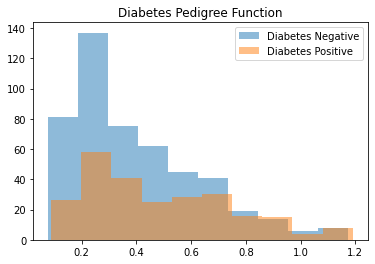

In [59]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['DiabetesPedigreeFunction'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['DiabetesPedigreeFunction'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Diabetes Pedigree Function')

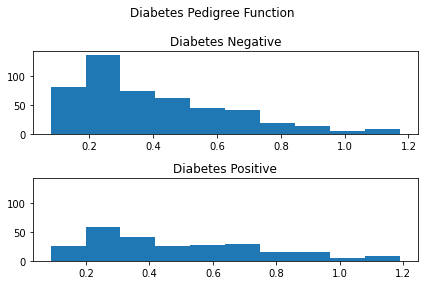

In [60]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Diabetes Pedigree Function')
axs[0].hist(df[df['Outcome'] == 0]['DiabetesPedigreeFunction'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['DiabetesPedigreeFunction'])
x = axs[1].set_title('Diabetes Positive')

### Edad (Age)

In [61]:
df['Age'].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

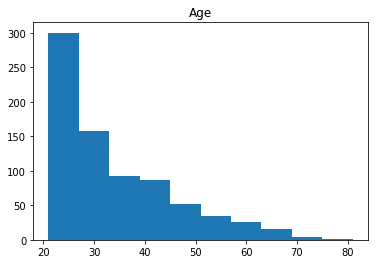

In [62]:
# Histogram 
plt.hist(df['Age'])
x = plt.title('Age')

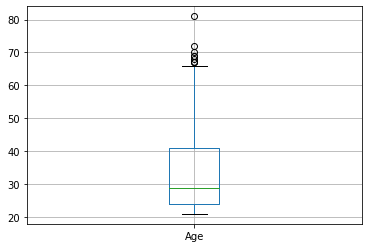

In [63]:
# Boxplot
df.boxplot(column=['Age'],return_type='axes');

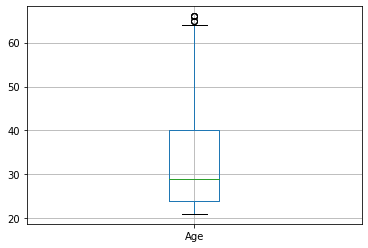

In [64]:
# Removing outliers from category
removeOutliers(df['Age'])
df.boxplot(column=['Age'],return_type='axes');

In [65]:
# Age in diabetes-negative
df[df['Outcome'] == 0]['Age'].describe()

count    493.000000
mean      30.632860
std       10.749603
min       21.000000
25%       23.000000
50%       26.000000
75%       36.000000
max       66.000000
Name: Age, dtype: float64

In [66]:
# Age in diabetes-positive
df[df['Outcome'] == 1]['Age'].describe()

count    266.000000
mean      36.830827
std       10.662115
min       21.000000
25%       28.000000
50%       36.000000
75%       44.000000
max       66.000000
Name: Age, dtype: float64

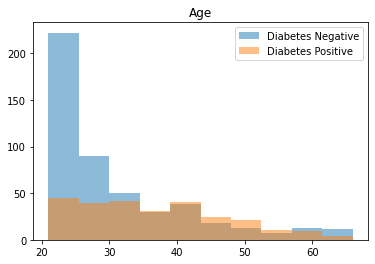

In [67]:
# Histograms

# Plotting histograms
plt.hist(df[df['Outcome'] == 0]['Age'],  alpha=0.5, label='Diabetes Negative')
plt.hist(df[df['Outcome'] == 1]['Age'],  alpha=0.5, label='Diabetes Positive')
plt.legend(loc='upper right')
x = plt.title('Age')

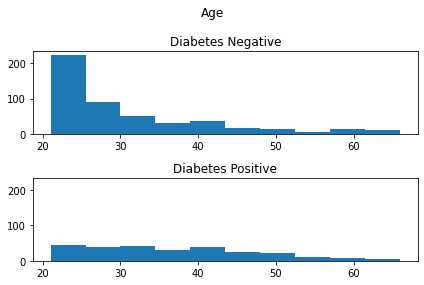

In [68]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
fig.suptitle('Age')
axs[0].hist(df[df['Outcome'] == 0]['Age'])
axs[0].set_title('Diabetes Negative')
axs[1].hist(df[df['Outcome'] == 1]['Age'])
x = axs[1].set_title('Diabetes Positive')

### Matriz de correlación
Se genera la matriz de correlación de el dataset filtrado. De esta forma, se busca identificar aquellas variables que tengan un alto grado de vinculación. En este caso, se podría prescindir de una de ellas para realizar la clasificación dado que las dos "aportan la misma información" al problema.

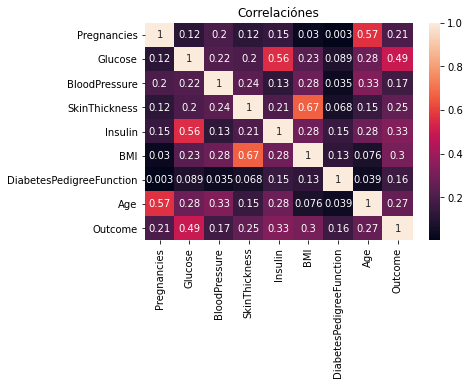

In [69]:
import seaborn as sb
# Correlation matrix
corrMatrix = df.corr()
ax = plt.axes()
sb.heatmap(corrMatrix, annot=True, ax=ax);
ax.set_title('Correlaciónes')
plt.show()